# Scraping Jumia Ecommerce Site: DSE HACKATHON

## Import libraries

In [1770]:
import requests as req
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import os

## Define function to fetch website html data

In [1771]:
def fetch_html_data(web_address):
    try:
        # print(f"\nFetching data from {web_address}...")
        res = req.get(web_address)
        return res
    except req.exceptions.RequestException as e:
        print('Stopped:', e)
    except TypeError as e:
        print('Stopped:', e)

# Define function to convert html data to BeautifulSoup object 

In [1772]:
def convert_web_data_to_beautiful_soup_obj(web_data):
    try:
        # print("Creating BeautifulSoup object...")
        soup_obj = BeautifulSoup(web_data.text, "html.parser")
        # print("Success! Object created!")
        return soup_obj
    except Exception as e:
        print("Stopped:", e)

### Create array of products on each page, add each to product dictionary & append to array iteratively

In [1773]:
all_products_list_df = []

def append_one_product_details_dictionary_to_list(pg):
    # print(f"Appending page {pg} products' details to array")
    
    page_products_details_soup = soup.find_all("article", class_="prd _fb col c-prd")
    
    for detail in page_products_details_soup:
        details_dict = {"name": detail.find("h3", class_="name").text.strip(),
                        "new_price": detail.find("div", class_="prc").text.strip(),
                        "old_price": detail.find("div", class_="old").text.strip() if detail.find("div", class_="old") else None,
                        "discount": detail.find("div", class_="bdg _dsct _sm").text.strip() if detail.find("div", class_="bdg _dsct _sm") else None,
                        "rating": detail.find("div", class_="stars _s").text.strip() if detail.find("div", class_="stars _s") else None,
                        "votes": detail.find("div", class_="rev").text.strip() if detail.find("div", class_="rev") else None}
        all_products_list_df.append(details_dict)


# len(product_details_clean)

### Declare the products' url & the total webpage count

In [1774]:
other_pages_url = "https://www.jumia.co.ke/all-products/?page="
webpage_num_total = 50

### Fetch webdata, convert to BeautifulSoup Object, add product details dictionary to list

In [1775]:
# If scraped products csv doesn't exist, run the scraper function below & save products to csv ELSE continue & read csv
if not os.path.exists('../data/raw/all_products_list_raw.csv'):
    for page in range(1, webpage_num_total+1, 1):
        other_pages_url = "https://www.jumia.co.ke/all-products/?page="
        page = str(page)
        other_pages_url = other_pages_url + page
        response = fetch_html_data(other_pages_url)
        # time.sleep(2.5)
        soup = convert_web_data_to_beautiful_soup_obj(response)
        append_one_product_details_dictionary_to_list(page)
    
    # Convert scraped list to dataframe
    df = pd.DataFrame(all_products_list_df)
    # Save scraped dataframe to csv to prevent scraping each time I run the notebook
    df.to_csv('../data/raw/all_products_list_raw.csv')

### Check product count

In [1776]:
# Read csv and specify index column to prevent creation of another redundant index
products_df = pd.read_csv('../data/raw/all_products_list_raw.csv', index_col=0)  # Read products list from csv
len(all_products_list_df)

0

### Inspect products list dataframe

In [1777]:
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,KSh 899,"KSh 1,560",42%,4.5 out of 5,4.5 out of 5(2218)
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,KSh 854,"KSh 1,460",42%,4.7 out of 5,4.7 out of 5(612)
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,"KSh 1,174","KSh 1,302",10%,4.7 out of 5,4.7 out of 5(1119)
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",KSh 728,"KSh 1,040",30%,4.6 out of 5,4.6 out of 5(830)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,KSh 655,"KSh 1,040",37%,4.6 out of 5,4.6 out of 5(623)


In [1778]:
products_df.shape

(2000, 6)

# Data Cleaning Section

### Clean new_price column

In [1779]:
# Remove currency name 'Ksh' & convert values to float
products_df['new_price'] = products_df['new_price'].apply(lambda x: x.split(' ')[1] if x is not None and isinstance(x,str) else x) 

In [1780]:
print(type(products_df['new_price'][1]))
print(products_df['new_price'].head())

<class 'str'>
0      899
1      854
2    1,174
3      728
4      655
Name: new_price, dtype: object


In [1781]:
# Remove comma from thousands price values
products_df['new_price'] = products_df['new_price'].apply(lambda x: x.replace(',','') if ',' in x and isinstance(x,str) else x)
products_df['new_price'].head()

0     899
1     854
2    1174
3     728
4     655
Name: new_price, dtype: object

In [1782]:
print(type(products_df['new_price'][1]))

<class 'str'>


In [1783]:
# Convert new_price column to float
products_df['new_price'] = products_df['new_price'].apply(lambda x: float(x))

In [1784]:
print(type(products_df['new_price'][1]))

<class 'numpy.float64'>


In [1785]:
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,"KSh 1,560",42%,4.5 out of 5,4.5 out of 5(2218)
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,"KSh 1,460",42%,4.7 out of 5,4.7 out of 5(612)
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,"KSh 1,302",10%,4.7 out of 5,4.7 out of 5(1119)
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,"KSh 1,040",30%,4.6 out of 5,4.6 out of 5(830)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,"KSh 1,040",37%,4.6 out of 5,4.6 out of 5(623)


In [1786]:
# Saving stage one data cleaning file to csv
products_df.to_csv("../data/processed/1_all_products_new_price_cleaned.csv")

### Clean old_price column

In [1787]:
# Read csv file cleaned in the previous stage (new_price column) & convert to dataframe
products_df = pd.read_csv("../data/processed/1_all_products_new_price_cleaned.csv", index_col=0)

# Use [:10] notation to print the first 10 values
products_df['old_price'].unique()[:10]

array(['KSh 1,560', 'KSh 1,460', 'KSh 1,302', 'KSh 1,040', 'KSh 5,610',
       'KSh 780', 'KSh 39,999', 'KSh 3,840', 'KSh 1,099', nan],
      dtype=object)

In [1788]:
# Remove currency name 'Ksh'
# type(products_df['old_price'][1])
products_df['old_price'] = products_df['old_price'].apply(lambda x: x.split(' ')[1] if x is not None and isinstance(x,str) else x)
products_df['old_price'].head()

0    1,560
1    1,460
2    1,302
3    1,040
4    1,040
Name: old_price, dtype: object

In [1789]:
# Remove commas from values
products_df['old_price'] = products_df['old_price'].apply(lambda x: x.replace(',','') if x is not None and isinstance(x,str) else x)
products_df['old_price'].head(10)

0     1560
1     1460
2     1302
3     1040
4     1040
5     1040
6     5610
7      780
8    39999
9     3840
Name: old_price, dtype: object

In [1790]:
# Convert the string values into floats
products_df['old_price'] = products_df['old_price'].apply(lambda x: float(x) if x is not None else x)
products_df['old_price'].head(10)

0     1560.0
1     1460.0
2     1302.0
3     1040.0
4     1040.0
5     1040.0
6     5610.0
7      780.0
8    39999.0
9     3840.0
Name: old_price, dtype: float64

In [1791]:
products_df['old_price']

0       1560.0
1       1460.0
2       1302.0
3       1040.0
4       1040.0
         ...  
1995    3500.0
1996    1600.0
1997       NaN
1998       NaN
1999     577.0
Name: old_price, Length: 2000, dtype: float64

In [1792]:
# Index 18 from above was null. So checking its type: 
type(products_df['old_price'][18])

numpy.float64

In [1793]:
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,42%,4.5 out of 5,4.5 out of 5(2218)
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,42%,4.7 out of 5,4.7 out of 5(612)
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,10%,4.7 out of 5,4.7 out of 5(1119)
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,30%,4.6 out of 5,4.6 out of 5(830)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,37%,4.6 out of 5,4.6 out of 5(623)


In [1794]:
# Saving stage two data cleaning file to csv
products_df.to_csv("../data/processed/2_all_products_old_price_cleaned.csv")

### Cleaning 'discount' column

In [1795]:
# Read file cleaned in the previous stage (old column) & convert to dataframe
products_df = pd.read_csv("../data/processed/2_all_products_old_price_cleaned.csv", index_col=0)

# Use [:10] notation to print the first 10 values
products_df['discount'].unique()[:10]

array(['42%', '10%', '30%', '37%', '35%', '25%', '17%', '27%', nan, '18%'],
      dtype=object)

In [1796]:
# Remove the percent sign
products_df['discount'] = products_df['discount'].apply(lambda x: x.replace('%','') if x is not None and isinstance(x,str) else x)
products_df['discount'].unique()

array(['42', '10', '30', '37', '35', '25', '17', '27', nan, '18', '14',
       '4', '31', '43', '11', '20', '9', '12', '34', '33', '29', '13',
       '28', '24', '5', '3', '32', '15', '48', '23', '38', '49', '46',
       '41', '16', '40', '39', '36', '26', '44', '22', '19', '7', '8',
       '21', '50', '45', '6', '1', '2', '47', '58', '59', '54', '53',
       '67', '70', '55', '60', '56'], dtype=object)

In [1797]:
# Convert values into float & divide by 100 to represent the percentages as decimal values
products_df['discount'] = products_df['discount'].apply(lambda x: float(x)/100 if x is not None else x)
products_df['discount'].unique()  # A numbers now floats and None replaced with NaN

array([0.42, 0.1 , 0.3 , 0.37, 0.35, 0.25, 0.17, 0.27,  nan, 0.18, 0.14,
       0.04, 0.31, 0.43, 0.11, 0.2 , 0.09, 0.12, 0.34, 0.33, 0.29, 0.13,
       0.28, 0.24, 0.05, 0.03, 0.32, 0.15, 0.48, 0.23, 0.38, 0.49, 0.46,
       0.41, 0.16, 0.4 , 0.39, 0.36, 0.26, 0.44, 0.22, 0.19, 0.07, 0.08,
       0.21, 0.5 , 0.45, 0.06, 0.01, 0.02, 0.47, 0.58, 0.59, 0.54, 0.53,
       0.67, 0.7 , 0.55, 0.6 , 0.56])

In [1798]:
# Check head once more
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5 out of 5,4.5 out of 5(2218)
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7 out of 5,4.7 out of 5(612)
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7 out of 5,4.7 out of 5(1119)
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6 out of 5,4.6 out of 5(830)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6 out of 5,4.6 out of 5(623)


In [1799]:
# Saving stage three data cleaning file to csv
products_df.to_csv("../data/processed/3_all_products_discount_cleaned.csv")

### Cleaning the rating column

In [1800]:
# Read file cleaned in the previous stage (discount column) & convert to dataframe
products_df = pd.read_csv("../data/processed/3_all_products_discount_cleaned.csv", index_col=0)

# Check for unique values first
products_df['rating'].unique()[:10]

array(['4.5 out of 5', '4.7 out of 5', '4.6 out of 5', '4.4 out of 5',
       '4.3 out of 5', '3.3 out of 5', '4 out of 5', '4.2 out of 5',
       '4.1 out of 5', '4.9 out of 5'], dtype=object)

In [1801]:
# Split rating string values into 4 elements and select the first element unless its None(left as is)
products_df['rating'] = products_df['rating'].apply(lambda x: x.split(' ')[0] if x is not None and isinstance(x,str) else x)
products_df['rating'].unique()

array(['4.5', '4.7', '4.6', '4.4', '4.3', '3.3', '4', '4.2', '4.1', '4.9',
       '5', '3.6', '3.7', nan, '3.9', '3.8', '3.4', '1', '4.8', '1.7',
       '3', '2.8', '3.5', '3.2', '3.1', '2.3', '1.5', '2', '2.7', '1.8'],
      dtype=object)

In [1802]:
# Convert the values into float
products_df['rating'] = products_df['rating'].apply(lambda x: float(x) if x is not None else x)
type(products_df['rating'][1])

numpy.float64

In [1803]:
products_df.head(20)

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,4.5 out of 5(2218)
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,4.7 out of 5(612)
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,4.7 out of 5(1119)
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,4.6 out of 5(830)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,4.6 out of 5(623)
5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.0,0.30,4.7,4.7 out of 5(220)
6,NIVEA Perfect & Radiant Luminous630 Anti Dark ...,3647.0,5610.0,0.35,4.4,4.4 out of 5(352)
7,NIVEA Perfect & Radiant Even Tone Day Cream SP...,585.0,780.0,0.25,4.4,4.4 out of 5(560)
8,"TCL 43S5400 S Series, 43"" Full HD Smart TV - B...",33245.0,39999.0,0.17,4.6,4.6 out of 5(44)
9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.0,0.42,4.6,4.6 out of 5(416)


In [1804]:
# Saving stage four data cleaning file to csv
products_df.to_csv("../data/processed/4_all_products_rating_cleaned.csv")

### Cleaning the 'votes' column

In [1805]:
# Read csv file cleaned in the previous stage (rating column) & convert to dataframe
products_df = pd.read_csv("../data/processed/4_all_products_rating_cleaned.csv", index_col=0)

# Explore unique values
products_df['votes'].unique()[:10]

array(['4.5 out of 5(2218)', '4.7 out of 5(612)', '4.7 out of 5(1119)',
       '4.6 out of 5(830)', '4.6 out of 5(623)', '4.7 out of 5(220)',
       '4.4 out of 5(352)', '4.4 out of 5(560)', '4.6 out of 5(44)',
       '4.6 out of 5(416)'], dtype=object)

In [1806]:
# Extract the votes count with string manipulation methods & convert values to integer values
products_df['votes'] = products_df['votes'].apply(lambda x: float(x.split('(')[1].split(')')[0]) if x is not None and isinstance(x,str) else x)
products_df['votes'].unique()[:15]

array([2218.,  612., 1119.,  830.,  623.,  220.,  352.,  560.,   44.,
        416.,   64.,  462.,   72.,  361.,   67.])

In [1807]:
products_df.head(20)

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,2218.0
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,612.0
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,1119.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,830.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,623.0
5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.0,0.30,4.7,220.0
6,NIVEA Perfect & Radiant Luminous630 Anti Dark ...,3647.0,5610.0,0.35,4.4,352.0
7,NIVEA Perfect & Radiant Even Tone Day Cream SP...,585.0,780.0,0.25,4.4,560.0
8,"TCL 43S5400 S Series, 43"" Full HD Smart TV - B...",33245.0,39999.0,0.17,4.6,44.0
9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.0,0.42,4.6,416.0


In [1808]:
# Saving stage five data cleaning file to csv
products_df.to_csv("../data/processed/5_all_products_votes_cleaned.csv")

## Dealing with null values

In [1809]:
# Read csv file cleaned in the previous stage (rating column) & convert to dataframe
products_df = pd.read_csv("../data/processed/5_all_products_votes_cleaned.csv", index_col=0)

In [1810]:
products_df.isnull().sum().idxmax()

'old_price'

In [1811]:
print(f"new_price nulls: {products_df.new_price.isnull().sum()}")
print(f"old_price nulls: {products_df.old_price.isnull().sum()}")
print(f"discount nulls: {products_df.discount.isnull().sum()}")
print(f"rating nulls: {products_df.rating.isnull().sum()}")
print(f"votes nulls: {products_df.votes.isnull().sum()}")

new_price nulls: 0
old_price nulls: 265
discount nulls: 265
rating nulls: 177
votes nulls: 177


### Fill null values in discount column 

In [1812]:
# Use discount column average to fill nulls
products_df['discount'] = products_df['discount'].fillna(round(products_df['discount'].mean(), 2))
products_df.discount.isnull().sum()

0

### Fill null values in old_price based on the discount column average

In [1813]:
def multiply_fill_old_price_column_nulls(row):
    new_price = row['new_price']
    discount_column_mean = round(products_df['discount'].mean(), 2)
    discount_multiplier = 1 - discount_column_mean
    
    if not pd.isna(row['old_price']):
        return row['old_price']
    return new_price * discount_column_mean
        
products_df['old_price'] = products_df.apply(multiply_fill_old_price_column_nulls, axis=1)
products_df.old_price.isnull().sum()

0

### Fill rating nulls with column mean

In [1814]:
products_df['rating'] = products_df['rating'].fillna(round(products_df['rating'].mean(), 2))
products_df.rating.isnull().sum()
# type(products_df['rating'][1])

0

### Fill votes nulls with column mean

In [1815]:
products_df['votes'] = products_df['votes'].fillna(round(products_df['votes'].mean(), 2))
products_df.votes.isnull().sum()

0

## Rechecking nulls for all columns again

In [1816]:
print(f"new_price nulls: {products_df.new_price.isnull().sum()}")
print(f"old_price nulls: {products_df.old_price.isnull().sum()}")
print(f"discount nulls: {products_df.discount.isnull().sum()}")
print(f"rating nulls: {products_df.rating.isnull().sum()}")
print(f"votes nulls: {products_df.votes.isnull().sum()}")

new_price nulls: 0
old_price nulls: 0
discount nulls: 0
rating nulls: 0
votes nulls: 0


In [1817]:
products_df.head(10)

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,2218.0
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,612.0
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,1119.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,830.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,623.0
5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.0,0.30,4.7,220.0
6,NIVEA Perfect & Radiant Luminous630 Anti Dark ...,3647.0,5610.0,0.35,4.4,352.0
7,NIVEA Perfect & Radiant Even Tone Day Cream SP...,585.0,780.0,0.25,4.4,560.0
8,"TCL 43S5400 S Series, 43"" Full HD Smart TV - B...",33245.0,39999.0,0.17,4.6,44.0
9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.0,0.42,4.6,416.0


In [1818]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       2000 non-null   object 
 1   new_price  2000 non-null   float64
 2   old_price  2000 non-null   float64
 3   discount   2000 non-null   float64
 4   rating     2000 non-null   float64
 5   votes      2000 non-null   float64
dtypes: float64(5), object(1)
memory usage: 109.4+ KB


In [1819]:
# Saving stage 6 data cleaning file to csv
products_df.to_csv("../data/final/6_all_products_all_columns_cleaned.csv")

### Assign cleaned dataframe to a new name

In [1820]:
# Read csv of the final data into dataframe
products_clean_df = pd.read_csv("../data/final/6_all_products_all_columns_cleaned.csv", index_col=0)
products_clean_df.head()

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,2218.0
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,612.0
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,1119.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,830.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,623.0


# DATA VISUALIZATION SECTION

### Summary stats of the data

In [1821]:
summary_stats = products_clean_df.describe()
summary_stats

,new_price,old_price,discount,rating,votes
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3196.821000,4022.427580,0.315720,4.117720,82.995500
std,7496.522099,9004.374828,0.125813,0.645906,251.460105
min,53.000000,22.080000,0.010000,1.000000,1.000000
25%,599.000000,741.750000,0.240000,3.900000,5.000000
50%,1000.000000,1457.500000,0.320000,4.200000,19.000000
75%,2247.000000,2800.000000,0.420000,4.500000,79.000000
max,106499.000000,106999.000000,0.700000,5.000000,4713.000000


### Deriving the correlation matrix

In [1822]:
# Returning correlation matrix for only the numerical columns
correlation_matrix = products_clean_df.corr(method='pearson', numeric_only=True)
# correlation_matrix.to_csv("results/datafiles/pearson_correlation.csv")
correlation_matrix

,new_price,old_price,discount,rating,votes
new_price,1.000000,0.924627,-0.163343,0.052990,-0.043446
old_price,0.924627,1.000000,-0.108572,0.042723,-0.048561
discount,-0.163343,-0.108572,1.000000,-0.093794,-0.039451
rating,0.052990,0.042723,-0.093794,1.000000,0.044273
votes,-0.043446,-0.048561,-0.039451,0.044273,1.000000


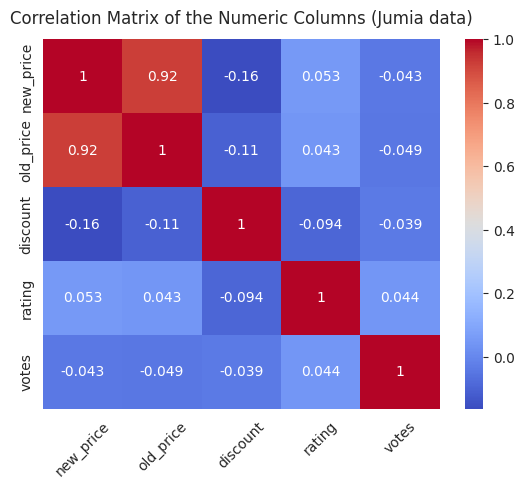

In [1855]:
plt.xticks(np.arange(len(products_clean_df.columns)), products_clean_df.columns, rotation=45)
plt.yticks(np.arange(len(products_clean_df.columns)), products_clean_df.columns, rotation=45)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of the Numeric Columns (Jumia data)', y=1.02)

plt.savefig("../results/plots/1_correlation_matrix_of_Jumia_products_numeric_data.png", bbox_inches="tight",pad_inches=2)

### Visualize top-rated products with at least 200 votes

In [1824]:
# First filter for products with at least 200 votes (More votes makes a product rating more reliable)
products_with_atleast_200_votes_df = products_clean_df[products_clean_df['votes'] >= 200]
products_with_atleast_200_votes_df

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,2218.0
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,612.0
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,1119.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,830.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,623.0
...,...,...,...,...,...,...
1407,Fashion 6 Pure Cotton Panties,1245.0,1800.0,0.31,4.4,292.0
1408,Fashion Sexiest Mock Neck Ribbed Bodycon Dress...,597.0,639.0,0.07,3.9,536.0
1412,Fashion 4 In 1 Ladies Handbags Women Shoulder ...,969.0,1358.0,0.29,3.4,221.0
1889,Ramtons RM/115 - 1.8L Auto Jug Kettle - White ...,2520.0,806.4,0.32,4.5,210.0


In [1825]:
# Check counts of products with rating at least 4.5
top_rated_products_df = products_with_atleast_200_votes_df[products_with_atleast_200_votes_df['rating'] >= 4.5]
top_rated_products_df

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,2218.0
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,612.0
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,1119.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,830.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,623.0
5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.0,0.30,4.7,220.0
9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.0,0.42,4.6,416.0
11,NIVEA MEN Deep Body Lotion For Men - 400ml (Pa...,1340.0,428.8,0.32,4.7,462.0
46,Garnier Vitamin C Booster Serum 30ml Twin Pack,2625.0,3500.0,0.25,4.6,443.0
49,Jameson Jameson Irish Whiskey - 1 Litre,2599.0,3827.0,0.32,4.6,242.0


In [1826]:
# Selecting only votes & rating column before plotting
new_top_rated_products_df = top_rated_products_df[['name','rating', 'votes']].reset_index(drop=True)
new_top_rated_products_df

,name,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,4.5,2218.0
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,4.7,612.0
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,4.7,1119.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",4.6,830.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,4.6,623.0
5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,4.7,220.0
6,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,4.6,416.0
7,NIVEA MEN Deep Body Lotion For Men - 400ml (Pa...,4.7,462.0
8,Garnier Vitamin C Booster Serum 30ml Twin Pack,4.6,443.0
9,Jameson Jameson Irish Whiskey - 1 Litre,4.6,242.0


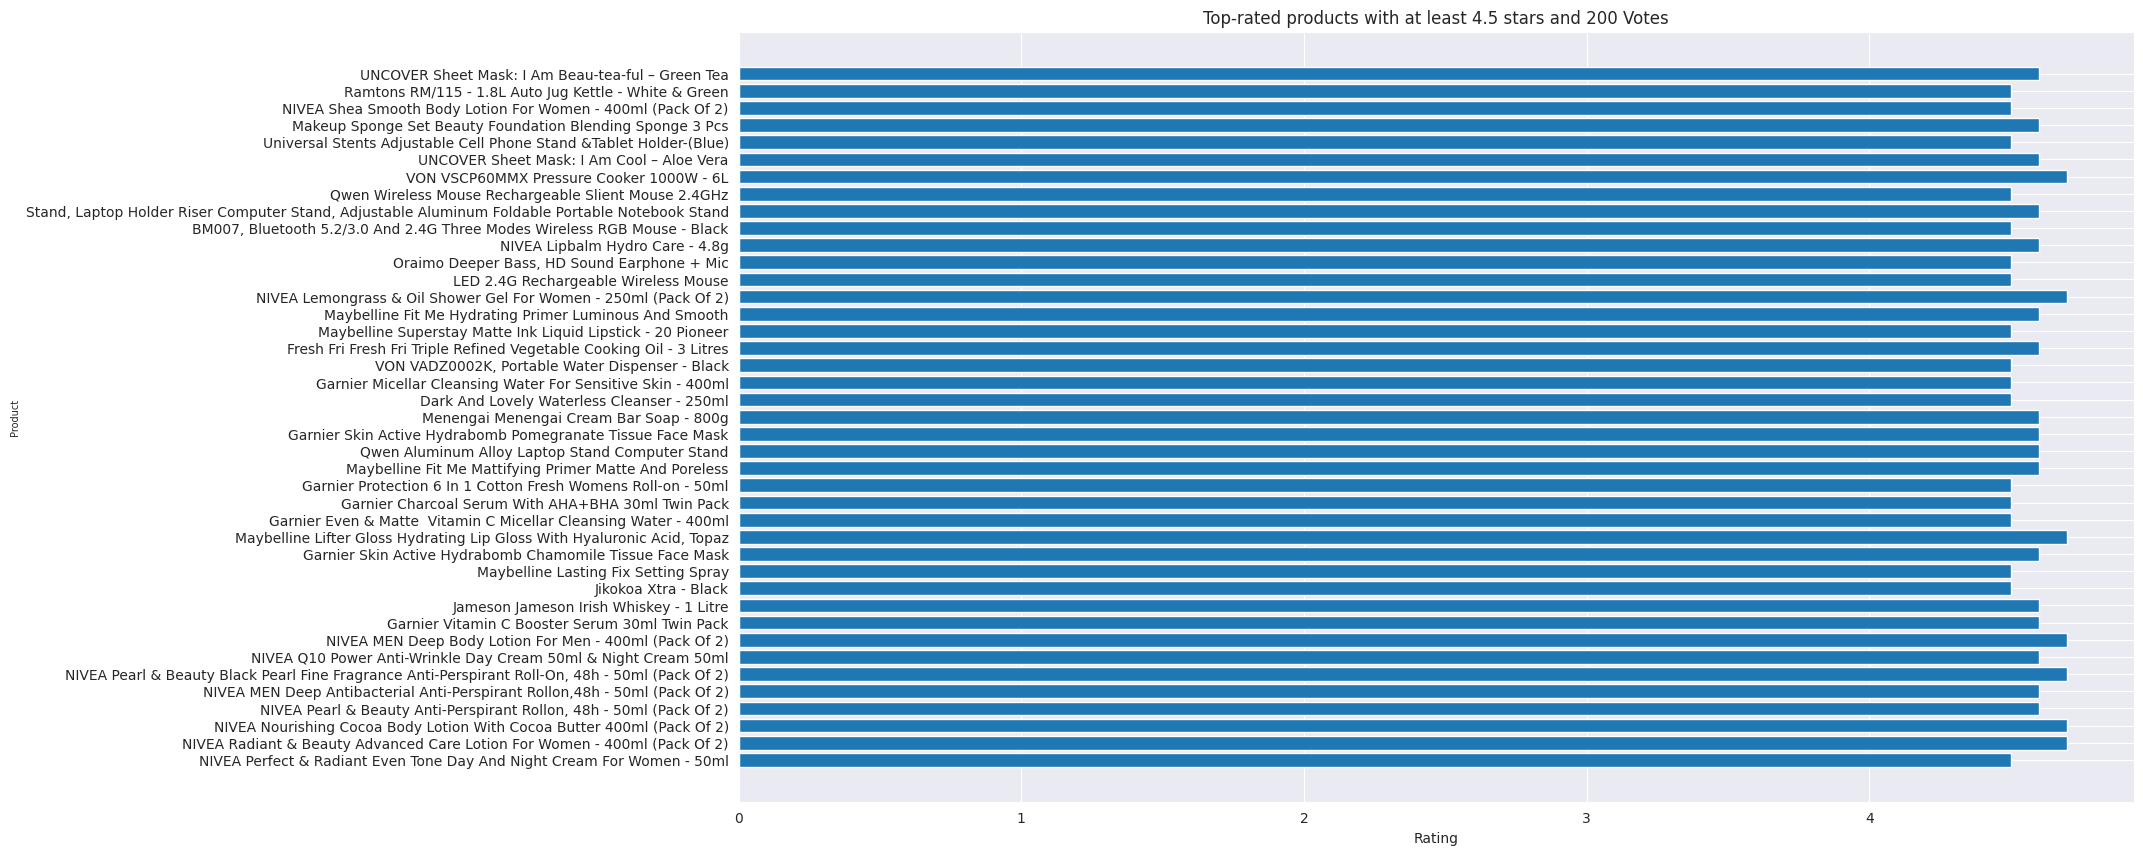

In [1856]:
# Creating a horizontal bar plot
plt.figure(figsize=(18,10))

plt.barh(new_top_rated_products_df['name'], new_top_rated_products_df['rating'])

plt.title("Top-rated products with at least 4.5 stars and 200 Votes")
plt.ylabel("Product", fontsize=7)
plt.xlabel("Rating")

# Save the plot to file
plt.savefig("../results/plots/2_products_4.5_stars_and_more_than_200_votes.png",bbox_inches='tight',pad_inches=2)

### Showing product price distribution: Histogram with Kernel density estimate (kde) curve

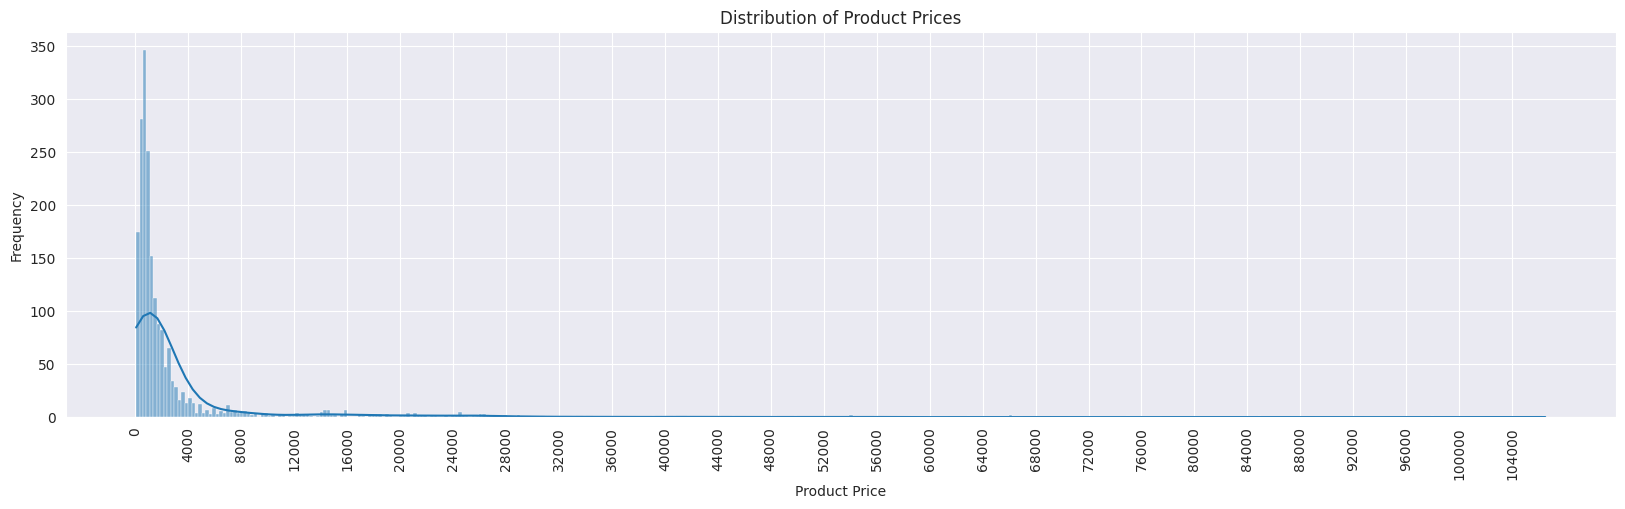

In [1857]:
plt.figure(figsize=(20, 5))
sns.histplot(products_clean_df['new_price'], kde=True)
plt.xlabel('Product Price')
plt.xticks(np.arange(0, max(products_clean_df['new_price'])+1, 4000),rotation=90)
plt.ylabel('Frequency')
plt.title('Distribution of Product Prices')

# Save the plot to file
plt.savefig("../results/plots/3_product_prices_histogram_with_kernel_estimate_curve.png",bbox_inches='tight',pad_inches=1)

### Visualizing discount distribution

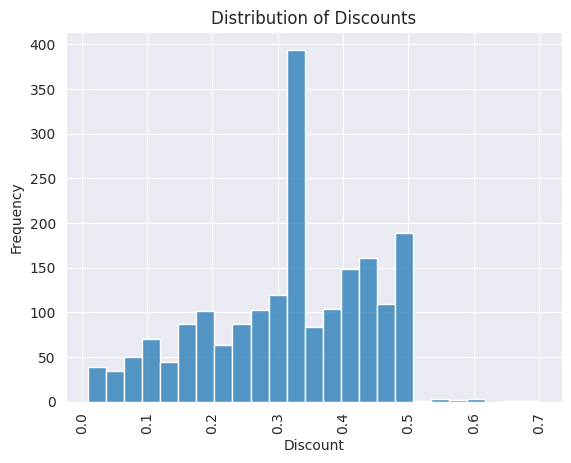

In [1858]:
sns.histplot(products_clean_df['discount'])
plt.xlabel('Discount')
# plt.xticks(np.arange(0,max(products_clean_df['discount'])+1,0.5),rotation=90)
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Distribution of Discounts')

# Save the plot to file
plt.savefig("../results/plots/4_product_discount_histogram.png",bbox_inches='tight',pad_inches=1)

### Visualizing rating distribution

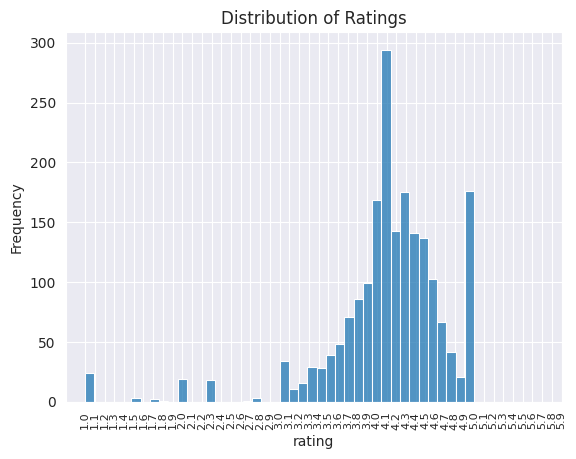

In [1859]:
sns.histplot(data=products_clean_df, x='rating')
plt.title('Distribution of Ratings')
plt.xticks(np.arange(1.0, max(products_clean_df['rating'])+1, 0.1),rotation=90,fontsize=8)
plt.ylabel("Frequency")

# Save plot to file
plt.savefig("../results/plots/5_ratings_distribution_histogram.png", bbox_inches="tight", pad_inches=1)

### Product Name Analysis

In [1832]:
words = ' '.join(products_clean_df['name']).split()
all_words = Counter(words)
# len(all_words)  # 4580

# Returning an array of tuples with all_words & their counts, then return first 10
all_words_counts = all_words.most_common()
all_words_counts[:10]

[('Fashion', 474),
 ('-', 363),
 ('+', 203),
 ('&', 144),
 ('Shoes', 135),
 ('Black', 134),
 ('With', 133),
 ('For', 120),
 ("Men's", 101),
 ('And', 88)]

In [1833]:
# Return only the alphabetical elements & their counts, & return the first 10
only_alpha_words_list = [(word, count) for word, count in all_words_counts if word.isalpha()]
only_alpha_words_list[:10]

[('Fashion', 474),
 ('Shoes', 135),
 ('Black', 134),
 ('With', 133),
 ('For', 120),
 ('And', 88),
 ('Set', 80),
 ('Bluetooth', 79),
 ('Wireless', 78),
 ('Casual', 75)]

In [1834]:
# Select the top 30 words
first_30_words = only_alpha_words_list[:31]
first_30_words

# Future: Use library to remove conjuctions such as 'and' from this list

[('Fashion', 474),
 ('Shoes', 135),
 ('Black', 134),
 ('With', 133),
 ('For', 120),
 ('And', 88),
 ('Set', 80),
 ('Bluetooth', 79),
 ('Wireless', 78),
 ('Casual', 75),
 ('Women', 72),
 ('Smart', 72),
 ('Men', 70),
 ('Ladies', 68),
 ('Electric', 65),
 ('Hair', 65),
 ('TV', 62),
 ('White', 62),
 ('Free', 55),
 ('Mens', 53),
 ('Oil', 51),
 ('Cable', 51),
 ('Soft', 49),
 ('Water', 48),
 ('In', 48),
 ('USB', 48),
 ('Blue', 48),
 ('C', 48),
 ('Power', 46),
 ('Cotton', 46),
 ('Sneakers', 43)]

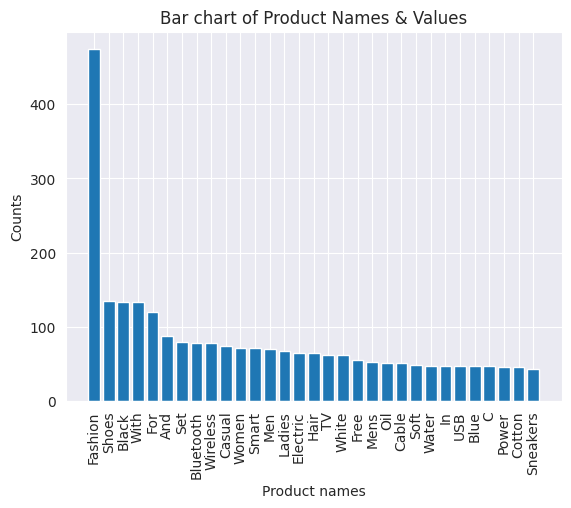

In [1860]:
# Plot a chart with the first 30 words
plt.bar([d[0] for d in first_30_words], [d[1] for d in first_30_words])
plt.xlabel("Product names")
plt.xticks(rotation=90)
plt.ylabel("Counts")
plt.title("Bar chart of Product Names & Values")

# Save plot to file
plt.savefig("../results/plots/6_barchart_top_30_product_names_counts.png", bbox_inches="tight", pad_inches=1)

### Creating pairplot showing relationship between various numerical columns

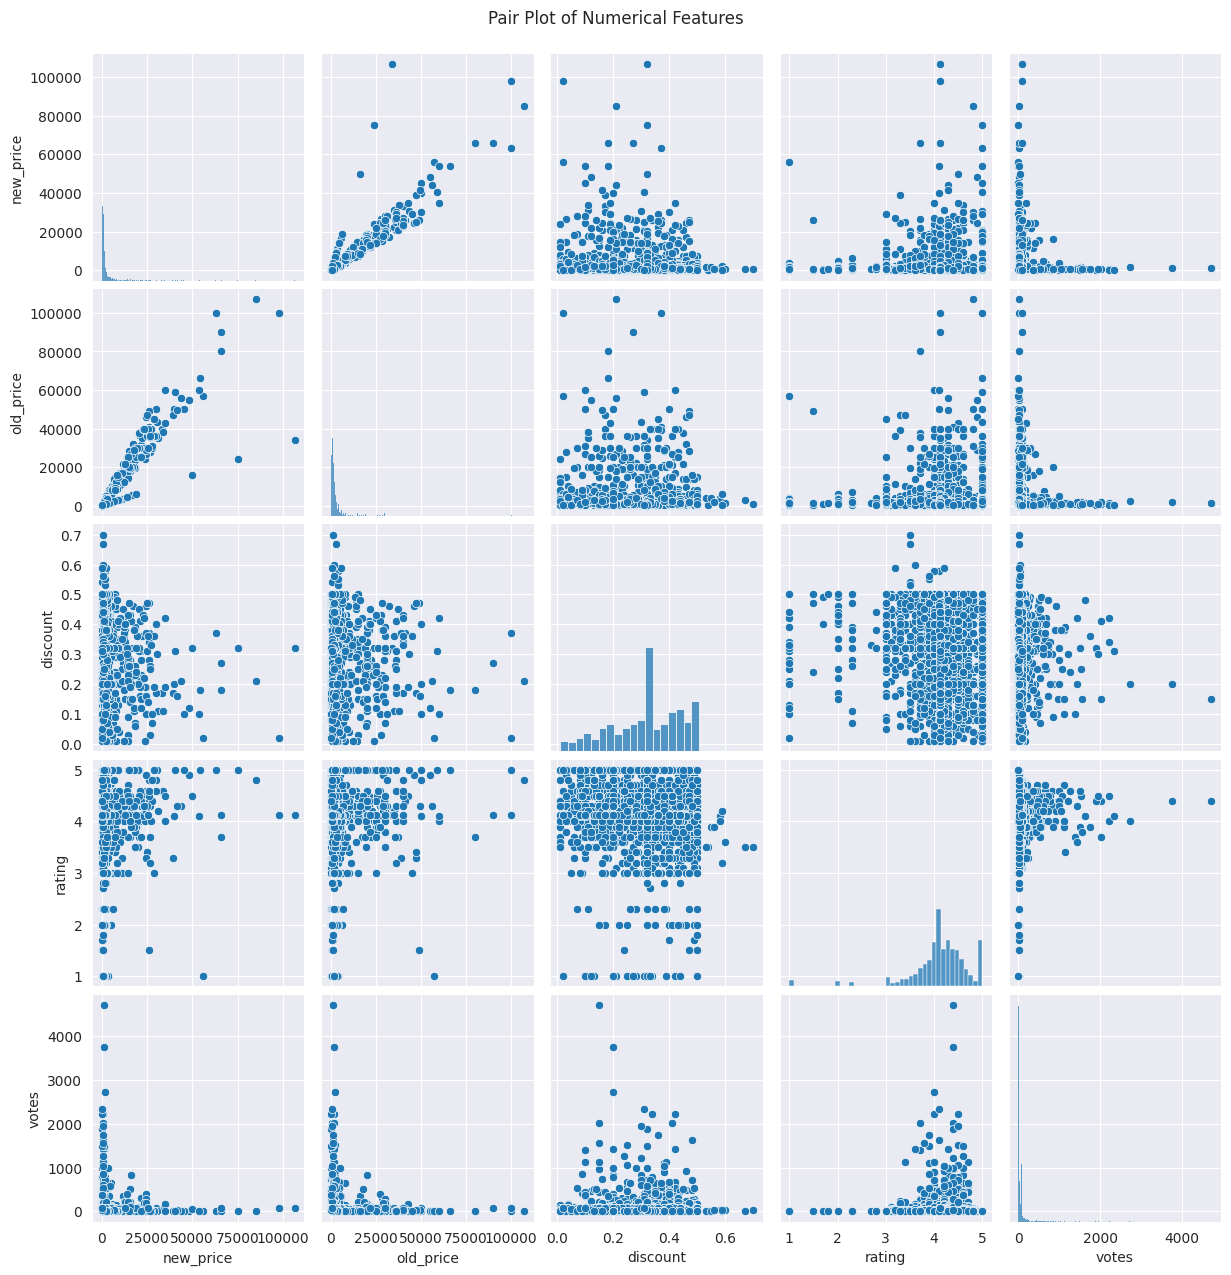

In [1854]:
sns.pairplot(products_clean_df)
plt.suptitle('Pair Plot of Numerical Features', y=1.02)

# Save to file
plt.savefig("../results/plots/7_pairplot_rltnships_between_all_numerical_columns.png", bbox_inches="tight", pad_inches=1)